In [18]:
from datasets import load_dataset
from PIL import Image, ImageDraw, ImageFont
from transformers import LayoutLMv2Processor, LayoutLMForTokenClassification
from transformers import Trainer, TrainingArguments

from functools import partial
from datasets import Sequence, Features, ClassLabel, Value, Array2D

import evaluate
import numpy as np
import torch

In [2]:


dataset = load_dataset("nielsr/funsd")

dataset


DatasetDict({
    train: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 149
    })
    test: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 50
    })
})

In [ ]:
dataset.save_to_disk("dataset/funsd/")

In [3]:
print("Train dataset:: ", len(dataset['train']))
print("Test dataset:: ", len(dataset['test']))

Train dataset::  149
Test dataset::  50


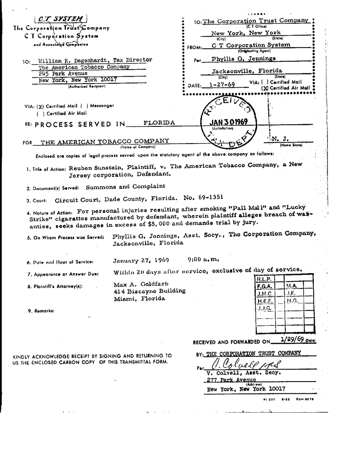

In [4]:
image = Image.open(dataset['train'][34]['image_path'])
image = image.convert('RGB')

image.resize((350, 450))

#### Class labels

In [5]:
labels = dataset['train'].features['ner_tags'].feature.names
print("Labels:: ", labels)

Labels::  ['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']


In [6]:
id2label = {v:k for v,k in enumerate(labels)}
label2id = {k:v for v,k in enumerate(labels)}

#### Tokenization..

In [7]:
processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", apply_ocr=False)

/Users/vivekr/Documents/vivek/projects/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


#### Define custom features

In [8]:
features = Features(
                        {
                            "input_ids": Sequence(feature=Value(dtype="int64")),
                            "attention_mask": Sequence(Value(dtype="int64")),
                            "token_type_ids": Sequence(Value(dtype="int64")),
                            "bbox": Array2D(dtype="int64", shape=(512, 4)),
                            "labels": Sequence(ClassLabel(names=labels))
                        }
)

def process(sample, processor=None):

    encoding = processor(
                            Image.open(sample["image_path"]).convert("RGB"),
                            sample['words'],
                            boxes=sample['bboxes'],
                            word_labels=sample['ner_tags'],
                            padding='max_length',
                            truncation=True,
    )
    del encoding['image']
    return encoding


proc_dataset = dataset.map(
    partial(process, processor=processor),
    remove_columns=["image_path", "words", "ner_tags", "id", "bboxes"],
    features=features
).with_format("torch")

print(proc_dataset["train"].features.keys())

dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'bbox', 'labels'])


In [9]:
model_id = "microsoft/layoutlm-base-uncased"

model = LayoutLMForTokenClassification.from_pretrained(model_id, num_labels=len(labels),
                                                       label2id=label2id, id2label=id2label)

Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
metric = evaluate.load("seqeval")

ner_labels = list(model.config.id2label.values())

In [11]:
ner_labels

['O',
 'B-HEADER',
 'I-HEADER',
 'B-QUESTION',
 'I-QUESTION',
 'B-ANSWER',
 'I-ANSWER']

In [12]:
def compute_metrics(p):

    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    all_predictions=[]
    all_labels=[]
    for prediction, label in zip(predictions, labels):
        for prediction_idx, label_idx in zip(prediction, label):
            if label_idx==-100:
                continue
            all_predictions.append(ner_labels[prediction_idx])
            all_labels.append(ner_labels[label_idx])
    
    return metric.compute(predictions=[all_predictions], references=[all_labels])

In [13]:
repository_id = "layoutlm-funsd"

training_args = TrainingArguments(
                        num_train_epochs=3,
                        per_device_train_batch_size=4,
                        per_device_eval_batch_size=2,
                        learning_rate=3e-5,
                        output_dir=f"{repository_id}/logs",
                        logging_strategy="epoch",
                        save_strategy="epoch",
                        evaluation_strategy="epoch",
                        save_total_limit=2,
                        load_best_model_at_end=True,
                        metric_for_best_model="overall_f1",

)

/Users/vivekr/Documents/vivek/projects/.venv/lib/python3.9/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [14]:
trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=proc_dataset['train'],
                eval_dataset=proc_dataset['test'],
                compute_metrics=compute_metrics
)

In [15]:
trainer.train()

 33%|███▎      | 38/114 [00:43<01:20,  1.06s/it]

{'loss': 1.5395, 'grad_norm': 7.9852986335754395, 'learning_rate': 1.9999999999999998e-05, 'epoch': 1.0}


Trainer is attempting to log a value of "{'precision': 0.28859060402684567, 'recall': 0.2657601977750309, 'f1': 0.2767052767052767, 'number': 809}" of type <class 'dict'> for key "eval/ANSWER" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.16666666666666666, 'recall': 0.008403361344537815, 'f1': 0.016, 'number': 119}" of type <class 'dict'> for key "eval/HEADER" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.5156124899919936, 'recall': 0.6046948356807512, 'f1': 0.5566119273984443, 'number': 1065}" of type <class 'dict'> for key "eval/QUESTION" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                
 33%|███▎      | 38/114 [00:48<01:20,  1.06s/it]

{'eval_loss': 1.0863604545593262, 'eval_ANSWER': {'precision': 0.28859060402684567, 'recall': 0.2657601977750309, 'f1': 0.2767052767052767, 'number': 809}, 'eval_HEADER': {'precision': 0.16666666666666666, 'recall': 0.008403361344537815, 'f1': 0.016, 'number': 119}, 'eval_QUESTION': {'precision': 0.5156124899919936, 'recall': 0.6046948356807512, 'f1': 0.5566119273984443, 'number': 1065}, 'eval_overall_precision': 0.43, 'eval_overall_recall': 0.4315102860010035, 'eval_overall_f1': 0.4307538191835712, 'eval_overall_accuracy': 0.626546812981555, 'eval_runtime': 5.002, 'eval_samples_per_second': 9.996, 'eval_steps_per_second': 4.998, 'epoch': 1.0}


 67%|██████▋   | 76/114 [01:49<00:52,  1.38s/it]

{'loss': 0.9261, 'grad_norm': 10.056544303894043, 'learning_rate': 9.999999999999999e-06, 'epoch': 2.0}


Trainer is attempting to log a value of "{'precision': 0.6259378349410504, 'recall': 0.7218788627935723, 'f1': 0.6704936854190585, 'number': 809}" of type <class 'dict'> for key "eval/ANSWER" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.07142857142857142, 'recall': 0.04201680672268908, 'f1': 0.052910052910052914, 'number': 119}" of type <class 'dict'> for key "eval/HEADER" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.6419457735247209, 'recall': 0.755868544600939, 'f1': 0.6942647692971109, 'number': 1065}" of type <class 'dict'> for key "eval/QUESTION" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                
 67%|██████▋   | 76/114 [01:55<00:52,  1.3

{'eval_loss': 0.7639896869659424, 'eval_ANSWER': {'precision': 0.6259378349410504, 'recall': 0.7218788627935723, 'f1': 0.6704936854190585, 'number': 809}, 'eval_HEADER': {'precision': 0.07142857142857142, 'recall': 0.04201680672268908, 'f1': 0.052910052910052914, 'number': 119}, 'eval_QUESTION': {'precision': 0.6419457735247209, 'recall': 0.755868544600939, 'f1': 0.6942647692971109, 'number': 1065}, 'eval_overall_precision': 0.617634027470093, 'eval_overall_recall': 0.6994480682388359, 'eval_overall_f1': 0.656, 'eval_overall_accuracy': 0.7647676862012608, 'eval_runtime': 6.0665, 'eval_samples_per_second': 8.242, 'eval_steps_per_second': 4.121, 'epoch': 2.0}


100%|██████████| 114/114 [03:03<00:00,  1.33s/it]

{'loss': 0.7074, 'grad_norm': 5.444178581237793, 'learning_rate': 0.0, 'epoch': 3.0}


Trainer is attempting to log a value of "{'precision': 0.661588683351469, 'recall': 0.7515451174289246, 'f1': 0.7037037037037037, 'number': 809}" of type <class 'dict'> for key "eval/ANSWER" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.07407407407407407, 'recall': 0.05042016806722689, 'f1': 0.06, 'number': 119}" of type <class 'dict'> for key "eval/HEADER" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.6634768740031898, 'recall': 0.7812206572769953, 'f1': 0.717550668391548, 'number': 1065}" of type <class 'dict'> for key "eval/QUESTION" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                 
100%|██████████| 114/114 [03:08<00:00,  1.33s/it]

{'eval_loss': 0.7122849822044373, 'eval_ANSWER': {'precision': 0.661588683351469, 'recall': 0.7515451174289246, 'f1': 0.7037037037037037, 'number': 809}, 'eval_HEADER': {'precision': 0.07407407407407407, 'recall': 0.05042016806722689, 'f1': 0.06, 'number': 119}, 'eval_QUESTION': {'precision': 0.6634768740031898, 'recall': 0.7812206572769953, 'f1': 0.717550668391548, 'number': 1065}, 'eval_overall_precision': 0.6415261756876663, 'eval_overall_recall': 0.7255393878575013, 'eval_overall_f1': 0.6809512597127384, 'eval_overall_accuracy': 0.7800607051132384, 'eval_runtime': 5.0218, 'eval_samples_per_second': 9.957, 'eval_steps_per_second': 4.978, 'epoch': 3.0}


100%|██████████| 114/114 [03:12<00:00,  1.69s/it]

{'train_runtime': 192.1342, 'train_samples_per_second': 2.326, 'train_steps_per_second': 0.593, 'train_loss': 1.0576653898807995, 'epoch': 3.0}


TrainOutput(global_step=114, training_loss=1.0576653898807995, metrics={'train_runtime': 192.1342, 'train_samples_per_second': 2.326, 'train_steps_per_second': 0.593, 'total_flos': 117615921638400.0, 'train_loss': 1.0576653898807995, 'epoch': 3.0})

In [16]:
processor.feature_extractor.apply_ocr=True

/Users/vivekr/Documents/vivek/projects/.venv/lib/python3.9/site-packages/transformers/models/layoutlmv2/processing_layoutlmv2.py:197: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Inference

/var/folders/63/2js74mr93212y9m1rrx97wbh0000gn/T/ipykernel_23051/3040636369.py:44: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("mps") if torch.has_mps else torch.device("cpu")
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[6, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 3, 4, 5, 6, 6, 3, 4, 4, 5, 6, 3, 4, 4, 4, 4, 4, 5, 6, 6, 3, 3, 4, 4, 4, 4, 4, 4, 4, 3, 5, 6, 5, 6, 6, 6, 3, 5, 6, 6, 6, 6, 3, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 6, 6, 6, 3, 5, 6, 6, 6, 6, 3, 4, 4, 0, 0, 3, 4, 4, 4, 4, 5, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 5, 6, 6, 3, 5, 6, 6, 6, 6, 0, 0, 6, 0, 6]
['I-ANSWER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'I-HEADER', 'O', 'O', 'O', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'B-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'I-QUESTION', 'B-QUESTION', 'B-ANSWER', 'I-ANSWER', 'B-ANSWER', 'I-ANSWER', 'I-ANSWER', 'I-ANSWER', 'B-QUESTION', 'B-ANSWER', 'I-ANSWER

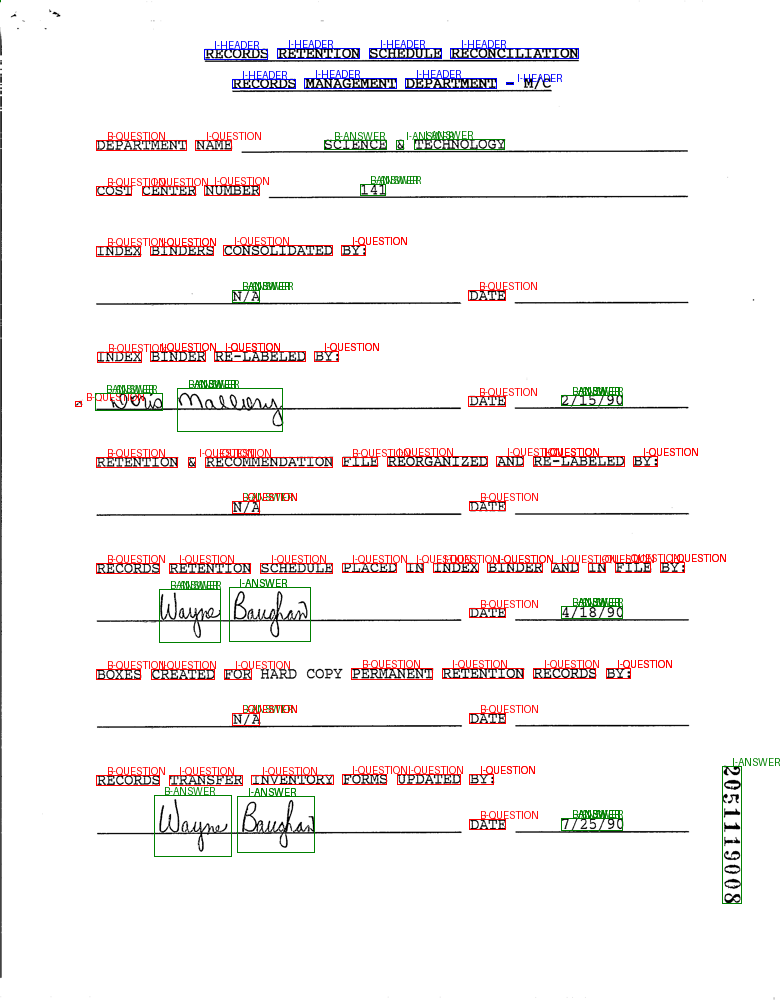

In [24]:
def unnormalize_box(bbox, width, height):

    return [
        width * (bbox[0]/1000),
        height * (bbox[1]/1000),
        width * (bbox[2]/1000),
        height * (bbox[3]/1000)
    ]

label2color = {

    "B-HEADER": "blue",
    "B-QUESTION": "red",
    "B-ANSWER": "green",
    "I-HEADER": "blue",
    "I-QUESTION": "red",
    "I-ANSWER": "green",
}

def draw_boxes(image, boxes, predictions):

    width, height = image.size

    normalizes_boxes = [unnormalize_box(box, width, height) for box in boxes]

    #draw boxes over predictions
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()

    for prediction, box in zip(predictions, normalizes_boxes):

        if prediction == "O":
            continue
        draw.rectangle(box, outline='black')
        draw.rectangle(box, outline=label2color[prediction])
        draw.text((box[0]+10, box[1]-10), text=prediction, fill=label2color[prediction], font=font)
    
    return image

def run_inference(path, model=model, processor=processor, output_image=True):

    image = Image.open(path).convert('RGB')
    
    device = torch.device("mps") if torch.has_mps else torch.device("cpu")

    # Move model to the MPS device
    model = model.to(device)

    # Move the input tensors to the MPS device
    encoding = processor(image, return_tensors='pt')
    del encoding['image']
    encoding = {k: v.to(device) for k, v in encoding.items()}

    outputs = model(**encoding)

    predictions = outputs.logits.argmax(-1).squeeze().tolist()

    print(predictions)

    #get labels
    labels = [model.config.id2label[prediction] for prediction in predictions]

    print(labels)

    if output_image:
        return draw_boxes(image, encoding['bbox'][0], labels)
    else:
        return labels

run_inference(dataset['test'][34]['image_path'])